In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import DataLoader, Subset
from IPython.display import clear_output
import random
import torch
import torchvision
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import transforms, models
import numpy as np
from scipy.linalg import sqrtm
import os
from torchvision.datasets import CIFAR10

## Discrimiatior Model for GANS
The Discriminator model for the GAN is based on the https://arxiv.org/abs/1406.2661 paper's model called Deep Convolutional GANs (DCGAN).
Architecture guidelines for stable Deep Convolutional GANs
* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

In [2]:
#Declare the parameters that might be needed.
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")

# Use parse_known_args to handle the lack of command-line arguments in a notebook
opt, unknown = parser.parse_known_args()
print(opt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Namespace(n_epochs=20, batch_size=128, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=32, channels=3, sample_interval=400)


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.ngf = 64
        self.out_channel = 3
        self.in_channel = 100
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(self.in_channel, self.ngf*4, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(self.ngf*4, 0.8),
            nn.ReLU(inplace=True),

            #Image shape dim(256, 4, 4)
            nn.ConvTranspose2d(self.ngf*4, self.ngf*2, kernel_size=4, stride=2, padding=1),   # Upsample x2
            nn.BatchNorm2d(self.ngf*2, 0.8),
            nn.ReLU(inplace=True),

            #Image shape dim(128, 8, 8)
            nn.ConvTranspose2d(self.ngf*2, self.ngf, kernel_size=4, stride=2, padding=1),   # Upsample x2
            nn.BatchNorm2d(self.ngf, 0.8),
            nn.ReLU(inplace=True),

            #Image shape dim(64, 16, 16)
            nn.ConvTranspose2d(self.ngf, self.out_channel, kernel_size=4, stride=2, padding=1),   # Upsample x2
            nn.Tanh()
          )

    #Noise z is of the dimmentions (100, 1, 1)
    def forward(self, z):
        out = self.conv_blocks(z)
        return out

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.ndf = 64
        self.in_channel = 3
        self.conv_blocks = nn.Sequential(
            #Input image of dimentions (3, 32, 32)
            nn.Conv2d(self.in_channel, self.ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            #Image dimentions (64, 16, 16)
            nn.Conv2d(self.ndf, self.ndf*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.ndf*2, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            #Image of the dimentions (128, 8, 8)
            nn.Conv2d(self.ndf*2, self.ndf*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.ndf*4, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            #Image of the dimentions (256, 4, 4)
            nn.Conv2d(self.ndf*4, 1, kernel_size=4, stride=1, padding=0)
        )
        self.sigmoid = nn.Sigmoid()


    #img of the dimentions (batch_size, 3, 32, 32)
    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.squeeze(1).squeeze(1).squeeze(1)
        out = self.sigmoid(out)
        return out

## Loading the Datasets

In [5]:
#Load the MNSIT-10 dataset on the notebook
def loadDataset():
  transform = transforms.Compose([
    transforms.ToTensor(),  # Converts [0, 255] uint8 → [0.0, 1.0] float32
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])  # → [0.0, 1.0] → [-1.0, 1.0]
])
  dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=True)
  return dataset, dataloader

## Training the models


In [6]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## 3.a Train this GAN model on the CIFAR-10 dataset.

In [35]:
def train_GAN(generator, discriminator, dataloader, optimizer_G, optimizer_D, adversarial_loss):
  g_losses = []
  d_losses = []
  for epoch in range(opt.n_epochs):
    g_loss_list = []
    d_loss_list = []
    generator.train()
    discriminator.train()
    for i, (imgs, _) in enumerate(dataloader):
      imgs = imgs.to(device)
      valid = torch.ones(imgs.size(0)).to(device)
      fake = torch.zeros(imgs.size(0)).to(device)

      #Create the noise to feed to the generator and forward pass
      #Sample the noise from the gaussian distribution
      z = torch.randn(imgs.size(0), opt.latent_dim, 1, 1).to(device)
      gen_imgs = generator(z)

      #Train the discriminator
      optimizer_D.zero_grad()

      #Train the discriminator on real images
      real_output_dis = discriminator(imgs)
      real_loss_dis = adversarial_loss(real_output_dis, valid)

      #Backward on the real loss
      real_loss_dis.backward()

      #Train the discriminator on fake images
      fake_output_dis = discriminator(gen_imgs.detach())
      fake_loss_dis = adversarial_loss(fake_output_dis, fake)

      #Backward on the fake loss
      fake_loss_dis.backward()

      #Sum of the losses and append
      d_loss = (real_loss_dis + fake_loss_dis) / 2
      d_loss_list.append(d_loss.item())

      #Backward pass on the model
      optimizer_D.step()
#______________________________________________________________________________________________________

      #Train the generator
      optimizer_G.zero_grad()

      #Create the noise to feed to the generator and forward pass
      #Sample the noise from the gaussian distribution
      z = torch.randn(imgs.size(0), opt.latent_dim, 1, 1).to(device)
      gen_imgs = generator(z)

      #Forward pass on the
      fake_output_gen = discriminator(gen_imgs)
      g_loss = adversarial_loss(fake_output_gen, valid)

      #Backward pass on the model
      g_loss.backward()
      optimizer_G.step()

      g_loss_list.append(g_loss.item())

      clear_output(wait=True)
      print(f"[Epoch {epoch+1}/{opt.n_epochs}] [Batch {i+1}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

    g_losses.append(np.mean(g_loss_list).item())
    d_losses.append(np.mean(d_loss_list).item())

    print(f"\n[Epoch {epoch}/{opt.n_epochs}] [D loss: {np.mean(d_loss_list)}] [G loss: {np.mean(g_loss_list)}]")

  return generator, discriminator, g_losses, d_losses

In [36]:
#Intitiliazing the models and the hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device=device)
discriminator = Discriminator().to(device=device)

#Define the loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(opt.b1, opt.b2))

#Intializing the weights of the models
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

#Try to overfit on a small subset of dataset
dataset, dataloader = loadDataset()

Files already downloaded and verified


In [37]:
generator, discriminator, g_loss, d_loss = train_GAN(generator, discriminator, dataloader, optimizer_G, optimizer_D, adversarial_loss)
# torch.save(generator.state_dict(), "Generator.pth")
# torch.save(discriminator.state_dict(), "Discriminator.pth")

[Epoch 20/20] [Batch 391/391] [D loss: 0.3606921434402466] [G loss: 1.524429202079773]

[Epoch 19/20] [D loss: 0.4124529412792772] [G loss: 1.7218705920307227]


In [48]:
# generator.load_state_dict(torch.load("/kaggle/input/generator/pytorch/default/1/Generator.pth", weights_only=True))
# discriminator.load_state_dict(torch.load("/kaggle/input/generator/pytorch/default/1/Discriminator.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
#Plot the generator loss and the discriminant losses
plt.plot(g_loss, label="Generator Loss")
plt.plot(d_loss, label="Discriminator Loss")
plt.legend()
location = "/kaggle/working/Normal_Training_1.png"
plt.savefig(location)
plt.show()

In [ ]:
#Test the output of the generator
z = torch.randn(1, opt.latent_dim, 1,1).to(device)
generator.eval()
gen_imgs = generator(z)
gen_imgs = (gen_imgs + 1) / 2
plt.imshow(gen_imgs.squeeze(0).permute((1, 2, 0)).detach().cpu().numpy())

## 3.b Plot a 10 x 10 grid of images generated by the trained model.

---




In [ ]:
# Plot a 10x10 grid of the images generated by the model
generator.eval()
fig, axs = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
  for j in range(10):
    z = torch.randn(1, opt.latent_dim, 1,1).to(device)
    gen_imgs = generator(z)
    gen_imgs = (gen_imgs + 1) / 2
    axs[i, j].imshow(gen_imgs.squeeze(0).permute((1, 2, 0)).detach().cpu().numpy())
    axs[i, j].axis('off')
location = "/kaggle/working/Normal_Training_grid_1.png"
plt.savefig(location)
plt.show()

## 3.c varying the number of times the generator and the discriminator are trained

#### More Generator steps

In [55]:
# --- TRAINING ---
def train_diff(discriminator, generator, criterion, optimizer_D, optimizer_G, dataloader, num_epochs, d_steps, g_steps):
    losses_g = []
    losses_d = []
    
    for epoch in range(num_epochs):
        losses_g_epoch = []
        losses_d_epoch = []
        generator.train()
        discriminator.train()
        
        for real_imgs, _ in dataloader:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
    
            real = torch.ones(batch_size).to(device)
            fake = torch.zeros(batch_size).to(device)
    
            # --- Train Discriminator ---
            for _ in range(d_steps):
                z = torch.randn(batch_size, opt.latent_dim, 1, 1).to(device)
                fake_imgs = generator(z).detach()
                d_real = discriminator(real_imgs)
                d_fake = discriminator(fake_imgs)
    
                loss_real = criterion(d_real, real)
                loss_fake = criterion(d_fake, fake)
                d_loss = (loss_real + loss_fake) / 2
    
                optimizer_D.zero_grad()
                d_loss.backward()
                optimizer_D.step()
                losses_d_epoch.append(d_loss.item())
    
            # --- Train Generator ---
            for _ in range(g_steps):
                z = torch.randn(batch_size, opt.latent_dim, 1, 1).to(device)
                generated_imgs = generator(z)
                d_gen = discriminator(generated_imgs)
                g_loss = criterion(d_gen, real)
    
                optimizer_G.zero_grad()
                g_loss.backward()
                optimizer_G.step()
                losses_g_epoch.append(g_loss.item())
            
        # Logging
        g_loss_mean = np.mean(losses_g_epoch)
        d_loss_mean = np.mean(losses_d_epoch)
        losses_g.append(g_loss_mean)
        losses_d.append(d_loss_mean)
        print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss_mean:.4f} | G Loss: {g_loss_mean:.4f}")
    return generator, discriminator, losses_g, losses_d

In [56]:
#Initialize the training hyper-parameters
batch_size = 128
latent_dim = 100
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset, dataloader = loadDataset()
#Number of steps for generator and discriminator
g_steps = 3         
d_steps = 1         

# --- INIT ---
generator_diff = Generator().to(device)
discriminator_diff = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator_diff.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator_diff.parameters(), lr=0.0002, betas=(0.5, 0.999))

Files already downloaded and verified


In [57]:
generator_diff, discriminator_diff, losses_g, losses_d = train_diff(discriminator_diff, 
                                                generator_diff, 
                                                criterion, 
                                                optimizer_D, 
                                                optimizer_G, 
                                                dataloader, 
                                                num_epochs, 
                                                d_steps, 
                                                g_steps)

Epoch [1/20] | D Loss: 0.6929 | G Loss: 0.7141
Epoch [2/20] | D Loss: 0.6969 | G Loss: 0.7121
Epoch [3/20] | D Loss: 0.6950 | G Loss: 0.6992
Epoch [4/20] | D Loss: 0.6941 | G Loss: 0.6960
Epoch [5/20] | D Loss: 0.6939 | G Loss: 0.6946
Epoch [6/20] | D Loss: 0.6937 | G Loss: 0.6934
Epoch [7/20] | D Loss: 0.6936 | G Loss: 0.6928
Epoch [8/20] | D Loss: 0.6935 | G Loss: 0.6929
Epoch [9/20] | D Loss: 0.6934 | G Loss: 0.6930
Epoch [10/20] | D Loss: 0.6933 | G Loss: 0.6930
Epoch [11/20] | D Loss: 0.6933 | G Loss: 0.6931
Epoch [12/20] | D Loss: 0.6933 | G Loss: 0.6931
Epoch [13/20] | D Loss: 0.6932 | G Loss: 0.6932
Epoch [14/20] | D Loss: 0.6932 | G Loss: 0.6932
Epoch [15/20] | D Loss: 0.6932 | G Loss: 0.6932
Epoch [16/20] | D Loss: 0.6932 | G Loss: 0.6932
Epoch [17/20] | D Loss: 0.6932 | G Loss: 0.6932
Epoch [18/20] | D Loss: 0.6932 | G Loss: 0.6932
Epoch [19/20] | D Loss: 0.6932 | G Loss: 0.6932
Epoch [20/20] | D Loss: 0.6932 | G Loss: 0.6933


<function matplotlib.pyplot.show(close=None, block=None)>

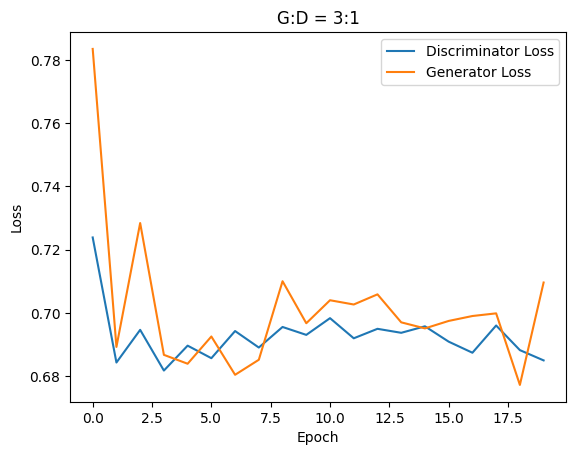

In [65]:
# --- PLOT LOSSES ---
plt.plot(losses_d, label="Discriminator Loss")
plt.plot(losses_g, label="Generator Loss")
plt.legend()
plt.title(f"G:D = {g_steps}:{d_steps}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("/kaggle/working/generator_diff_4.png")
plt.show

In [39]:
torch.save(generator_diff.state_dict(), "Generator_diff.pth")
torch.save(discriminator_diff.state_dict(), "Discriminator_diff.pth")

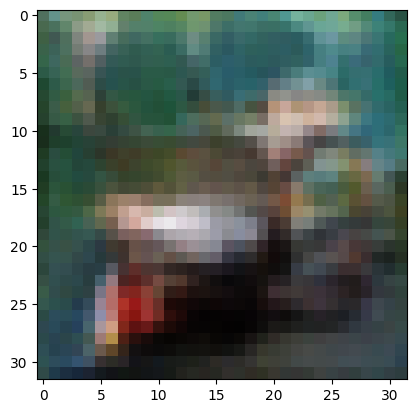

In [67]:
#Test the output of the generator
z = torch.randn(1, opt.latent_dim, 1,1).to(device)
generator_diff.eval()
gen_imgs = generator_diff(z)
gen_imgs = (gen_imgs + 1) / 2
plt.imshow(gen_imgs.squeeze(0).permute((1, 2, 0)).detach().cpu().numpy())

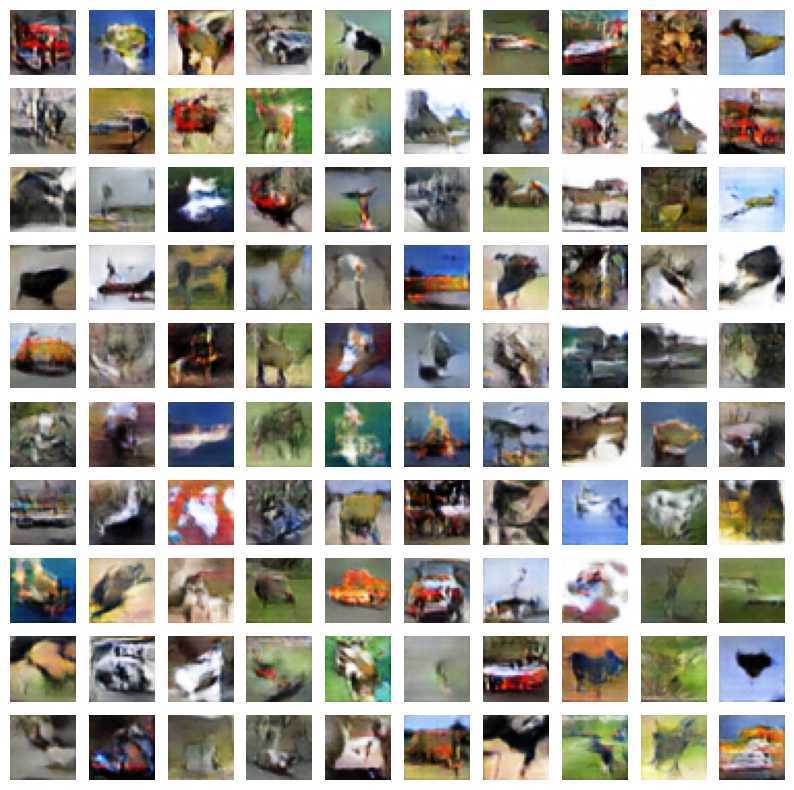

In [68]:
# Plot a 10x10 grid of the images generated by the model
generator_diff.eval()
fig, axs = plt.subplots(10, 10, figsize=(10,10))
for i in range(10): 
  for j in range(10):
    z = torch.randn(1, opt.latent_dim, 1,1).to(device)
    gen_imgs = generator_diff(z)
    gen_imgs = (gen_imgs + 1) / 2
    axs[i, j].imshow(gen_imgs.squeeze(0).permute((1, 2, 0)).detach().cpu().numpy())
    axs[i, j].axis('off')
plt.savefig("/kaggle/working/generator_diff_10x10.png")
plt.show()


#### More Discriminator steps

In [33]:
#Initialize the training hyper-parameters
batch_size = 128
latent_dim = 100
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset, dataloader = loadDataset()
#Number of steps for generator and discriminator
g_steps = 1         
d_steps = 3        

# --- INIT ---
generator_diff_1 = Generator().to(device)
discriminator_diff_1 = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator_diff_1.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator_diff_1.parameters(), lr=0.0002, betas=(0.5, 0.999))

Files already downloaded and verified


In [34]:
generator_diff, discriminator_diff, losses_g, losses_d = train_diff(discriminator_diff_1, 
                                                generator_diff_1, 
                                                criterion, 
                                                optimizer_D, 
                                                optimizer_G, 
                                                dataloader, 
                                                num_epochs, 
                                                d_steps, 
                                                g_steps)

Epoch [1/20] | D Loss: 0.0523 | G Loss: 5.4907
Epoch [2/20] | D Loss: 0.0774 | G Loss: 4.6828
Epoch [3/20] | D Loss: 0.0825 | G Loss: 4.7804
Epoch [4/20] | D Loss: 0.1034 | G Loss: 4.4342
Epoch [5/20] | D Loss: 0.0788 | G Loss: 4.8594
Epoch [6/20] | D Loss: 0.0916 | G Loss: 4.8270
Epoch [7/20] | D Loss: 0.1033 | G Loss: 4.4983
Epoch [8/20] | D Loss: 0.1193 | G Loss: 4.4071
Epoch [9/20] | D Loss: 0.1114 | G Loss: 4.3469
Epoch [10/20] | D Loss: 0.1310 | G Loss: 4.3809
Epoch [11/20] | D Loss: 0.1193 | G Loss: 4.2333
Epoch [12/20] | D Loss: 0.1387 | G Loss: 4.2904
Epoch [13/20] | D Loss: 0.1360 | G Loss: 4.4220
Epoch [14/20] | D Loss: 0.2341 | G Loss: 4.2985
Epoch [15/20] | D Loss: 0.1209 | G Loss: 4.2822
Epoch [16/20] | D Loss: 0.1659 | G Loss: 4.2950
Epoch [17/20] | D Loss: 0.1355 | G Loss: 4.3279
Epoch [18/20] | D Loss: 0.2012 | G Loss: 4.2433
Epoch [19/20] | D Loss: 0.1602 | G Loss: 4.2392
Epoch [20/20] | D Loss: 0.1700 | G Loss: 4.2110


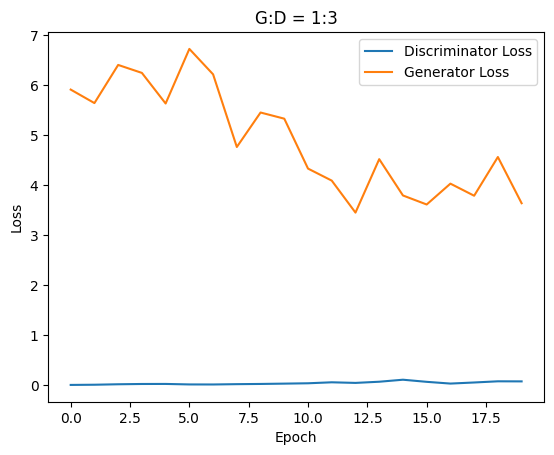

In [9]:
# --- PLOT LOSSES ---
plt.plot(losses_d, label="Discriminator Loss")
plt.plot(losses_g, label="Generator Loss")
plt.legend()
plt.title(f"G:D = {g_steps}:{d_steps}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("/kaggle/working/generator_diff_1_3.png")
plt.show()

In [40]:
torch.save(generator_diff_1.state_dict(), "Generator_diff_1.pth")
torch.save(discriminator_diff_1.state_dict(), "Discriminator_diff_1.pth")

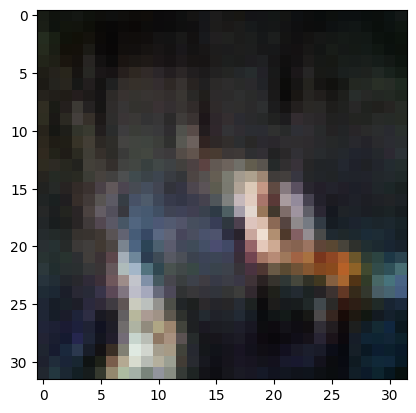

In [11]:
#Test the output of the generator
z = torch.randn(1, opt.latent_dim, 1,1).to(device)
generator_diff_1.eval()
gen_imgs = generator_diff_1(z)
gen_imgs = (gen_imgs + 1) / 2
plt.imshow(gen_imgs.squeeze(0).permute((1, 2, 0)).detach().cpu().numpy())

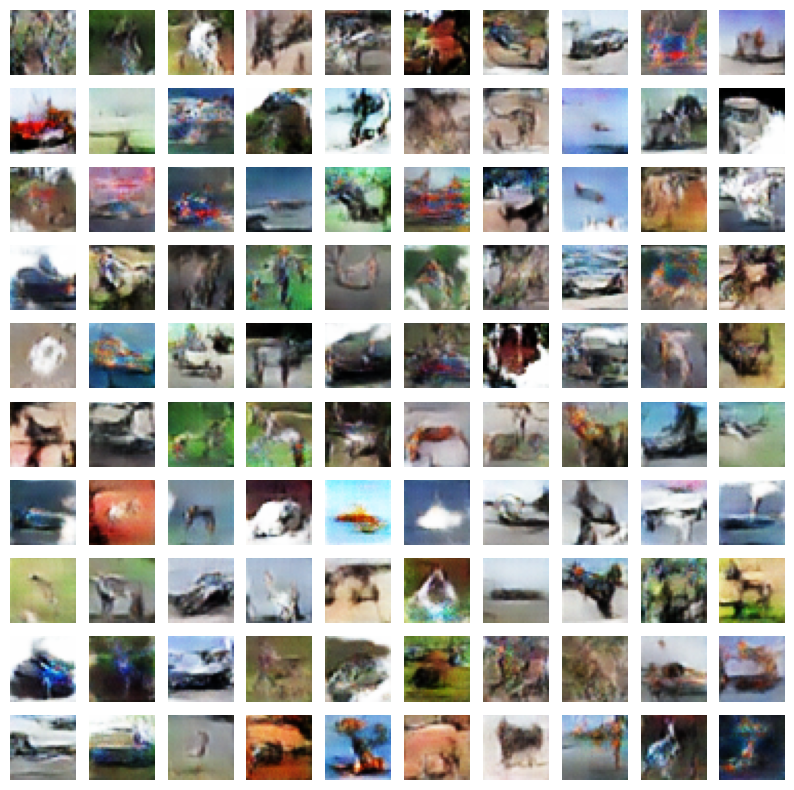

In [12]:
# Plot a 10x10 grid of the images generated by the model
generator_diff_1.eval()
fig, axs = plt.subplots(10, 10, figsize=(10,10))
for i in range(10): 
  for j in range(10):
    z = torch.randn(1, opt.latent_dim, 1,1).to(device)
    gen_imgs = generator_diff_1(z)
    gen_imgs = (gen_imgs + 1) / 2
    axs[i, j].imshow(gen_imgs.squeeze(0).permute((1, 2, 0)).detach().cpu().numpy())
    axs[i, j].axis('off')
plt.savefig("/kaggle/working/generator_diff_1_10x10.png")
plt.show()


### 3.d Compute FID (wiki) between 1000 real and generated images. Document FID variation for experiment 3 above to quantify the generation quality.

In [14]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):

        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        inception = torchvision.models.inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = torch.nn.functional.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception = InceptionV3([block_idx])
inception.to(device)
print("Done")

def get_activations(inception_model, image_tensors, device, dims=2048):
    """
        image_tensors -> (B, 3, 32, 32), type -> torch.tensor
    """
    # set eval mode
    inception_model.eval()

    # create a dataloader
    loader = DataLoader(image_tensors, batch_size=32, shuffle=False)

    # preds
    activations = None

    with torch.no_grad():
        for batch_images in loader:
            # push to device
            if(len(batch_images) == 2):
                batch_images = batch_images[0]
            batch_images = batch_images.to(device)

            # run model forward
            out = inception_model(batch_images)
            # out -> (B, 2048, 1, 1), so squeezes
            out = torch.squeeze(out[0], dim=[2, 3])
            out = out.cpu().numpy()
            # store the preds
            if activations is None:
                activations = out
            else:
                activations = np.vstack((activations, out))

    return activations


def get_activation_stats(activations):
    return np.mean(activations, axis=0), np.cov(activations, rowvar=False)


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    distance = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return distance


# we have to calculate FID between real and fake images.
def calculate_fid(gen, cifar10_dataset, inception_model, num_samples, device):
    # generate fake data first
    _, fake_data = generate_fake_data(gen, num_samples=num_samples, device=device)
    # fake_data -> (num_samples, 3, 32, 32)

    # get num samples real data
    normalize_transforms = transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.uint8, scale=True),
        transforms.ToDtype(torch.float32, scale=True),
    ])
    real_dataset = MyDataset(cifar10_dataset, normalize_transforms)
    # generate num_samples indices
    indices = np.arange(len(real_dataset))
    # np.random.shuffle(indices)
    real_data = torch.stack([real_dataset[x] for x in indices[:num_samples]], dim=0)
    # real_data -> (num_samples, 3, 32, 32)

    print(f"Shape of real data = {real_data.shape}")
    print(f"Shape of fake data = {fake_data.shape}")

    # get the predictions on real data
    real_activations = get_activations(inception_model, real_data, device)
    print(f"Real activations shape = {real_activations.shape}")

    # get the predictions on fake data
    fake_activations = get_activations(inception_model, fake_data, device)
    print(f"Fake activations shape = {fake_activations.shape}")

    # get activation stats
    real_mu, real_sigma = get_activation_stats(real_activations)
    fake_mu, fake_sigma = get_activation_stats(fake_activations)

    distance = calculate_frechet_distance(real_mu, real_sigma, fake_mu, fake_sigma)
    return distance

For Normal Generator

In [ ]:
# Get 1000 real images from CIFAR-10
from scipy import linalg
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
real_data = Subset(datasets.CIFAR10(root='./data', train=True, download=False, transform=transform), range(1000))
fake_images = []

inception_model = InceptionV3().to(device)
# get the predictions on real data
real_activations = get_activations(inception_model, real_data, device)
print(f"Real activations shape = {real_activations.shape}")

# get activation stats
real_mu, real_sigma = get_activation_stats(real_activations)
with torch.no_grad():
    for _ in range(20):
        z = torch.randn(50, 100,1, 1).to(device)
        imgs = generator(z)
        imgs = (imgs + 1) / 2  # Unnormalize to [0,1]
        fake_images.append(imgs.cpu())
fake_data = torch.cat(fake_images, dim=0)
# get the predictions on fake data
fake_activations = get_activations(inception_model, fake_data, device)
print(f"Fake activations shape = {fake_activations.shape}")
fake_mu, fake_sigma = get_activation_stats(fake_activations)
distance = calculate_frechet_distance(real_mu, real_sigma, fake_mu, fake_sigma)
print(distance)

For 3:1 Generator Discriminator ratios

In [64]:
# Get 1000 real images from CIFAR-10
from scipy import linalg
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
real_data = Subset(datasets.CIFAR10(root='./data', train=True, download=False, transform=transform), range(1000))
fake_images = []

inception_model = InceptionV3().to(device)
# get the predictions on real data
real_activations = get_activations(inception_model, real_data, device)
print(f"Real activations shape = {real_activations.shape}")

# get activation stats
real_mu, real_sigma = get_activation_stats(real_activations)
with torch.no_grad():
    for _ in range(20):
        z = torch.randn(50, 100,1, 1).to(device)
        imgs = generator_diff(z)
        imgs = (imgs + 1) / 2  # Unnormalize to [0,1]
        fake_images.append(imgs.cpu())
fake_data = torch.cat(fake_images, dim=0)
# get the predictions on fake data
fake_activations = get_activations(inception_model, fake_data, device)
print(f"Fake activations shape = {fake_activations.shape}")
fake_mu, fake_sigma = get_activation_stats(fake_activations)
distance = calculate_frechet_distance(real_mu, real_sigma, fake_mu, fake_sigma)
print(distance)

FID Score (Manual): 119.82


For 1:3 Generator Discriminator ratios

In [15]:
# Get 1000 real images from CIFAR-10
from scipy import linalg
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
real_data = Subset(datasets.CIFAR10(root='./data', train=True, download=False, transform=transform), range(1000))
fake_images = []

inception_model = InceptionV3().to(device)
# get the predictions on real data
real_activations = get_activations(inception_model, real_data, device)
print(f"Real activations shape = {real_activations.shape}")

# get activation stats
real_mu, real_sigma = get_activation_stats(real_activations)
with torch.no_grad():
    for _ in range(20):
        z = torch.randn(50, 100,1, 1).to(device)
        imgs = generator_diff_1(z)
        imgs = (imgs + 1) / 2  # Unnormalize to [0,1]
        fake_images.append(imgs.cpu())
fake_data = torch.cat(fake_images, dim=0)
# get the predictions on fake data
fake_activations = get_activations(inception_model, fake_data, device)
print(f"Fake activations shape = {fake_activations.shape}")
fake_mu, fake_sigma = get_activation_stats(fake_activations)
distance = calculate_frechet_distance(real_mu, real_sigma, fake_mu, fake_sigma)
print(distance)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 221MB/s] 


FID Score (Manual): 128.75


### 3.e Plot generated images obtained via linear interpolation between a pair of latent vectors

In [11]:
count = 0

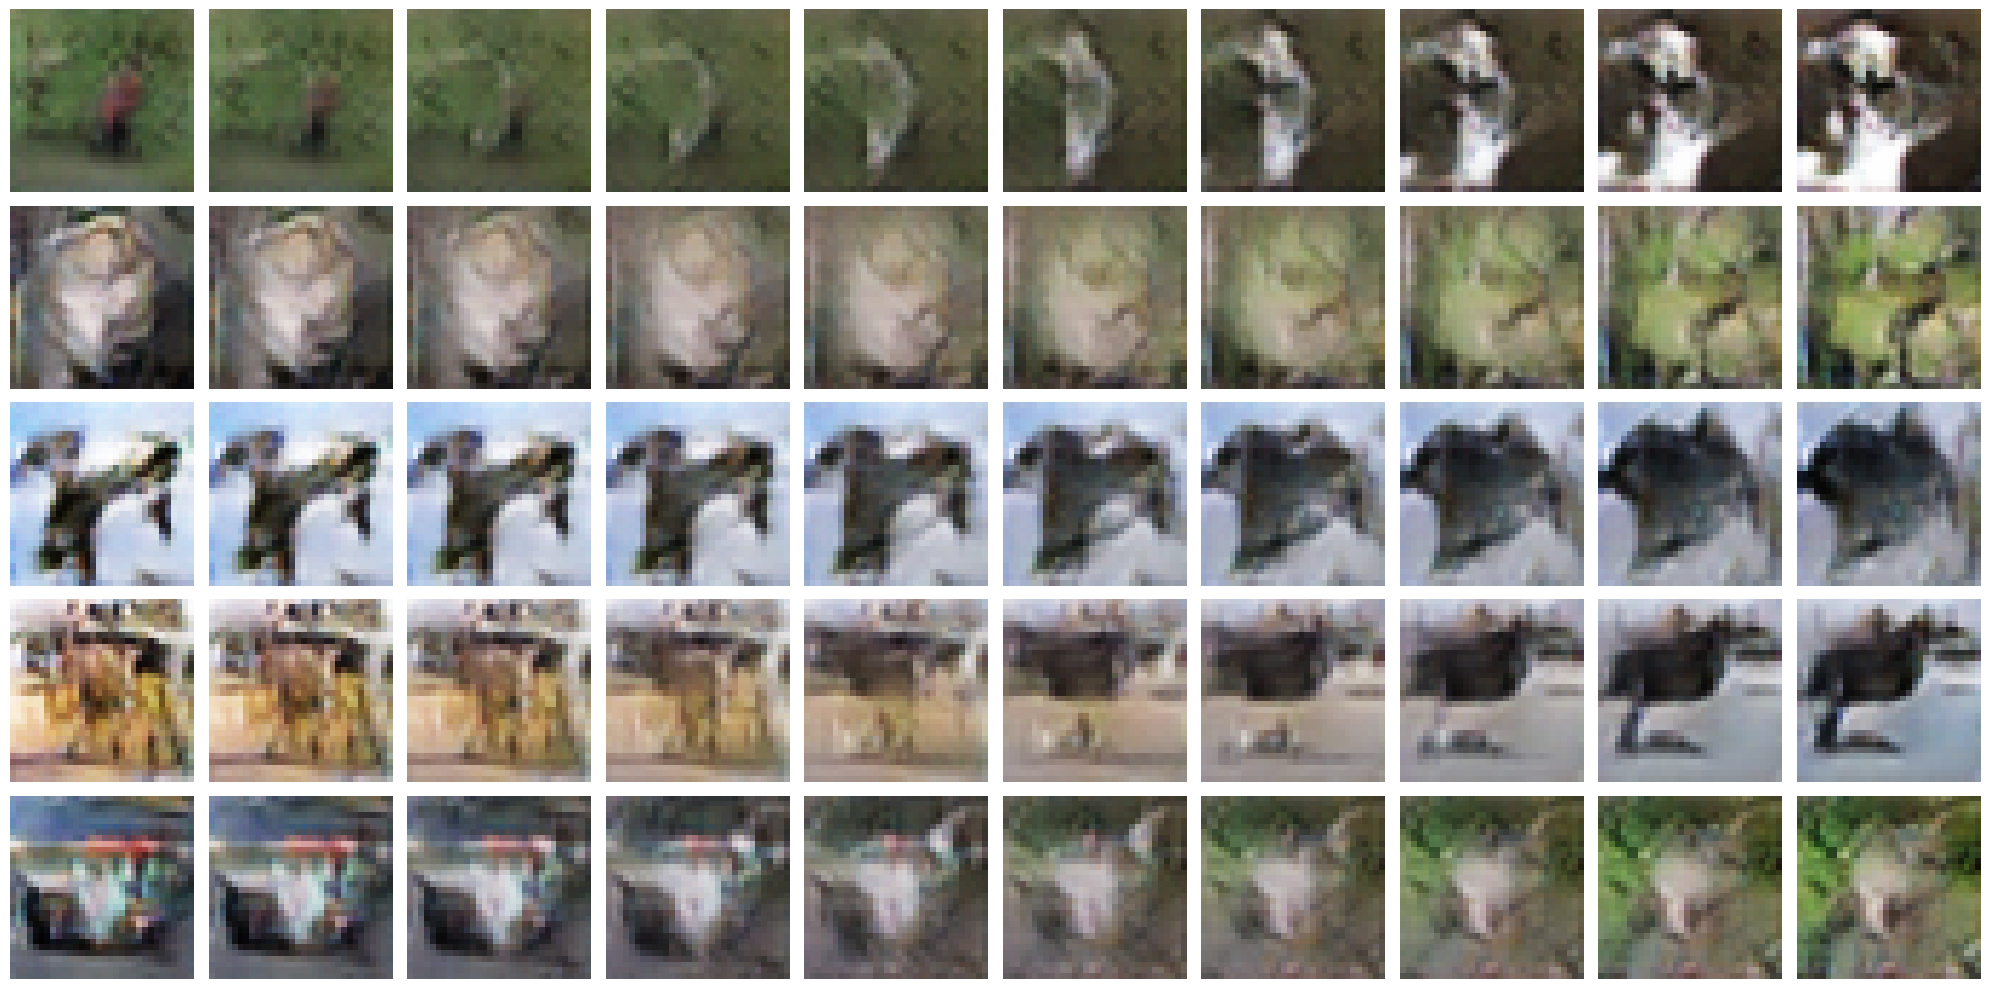

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load your trained generator
generator_diff.eval()

def interpolate(z1, z2, steps=10):
    # Linearly interpolate between z1 and z2
    return [(1 - alpha) * z1 + alpha * z2 for alpha in np.linspace(0, 1, steps)]
def walkLatentSpace(generator):
    # Sample two random latent vectors
    z1 = torch.randn(1, 100, 1, 1).to(device)
    z2 = torch.randn(1, 100, 1, 1).to(device)
    
    # Interpolate between them
    interpolated_z = interpolate(z1, z2, steps=10)
    interpolated_z = torch.cat(interpolated_z, dim=0)
    
    # Generate images
    with torch.no_grad():
        gen_images = generator(interpolated_z).cpu()
    
    # Convert to [0, 1] for plotting
    gen_images = (gen_images + 1) / 2
    return gen_images

num_rows = 5
steps = 10

# Create the figure and grid of subplots
fig, axes = plt.subplots(num_rows, steps, figsize=(steps * 2, num_rows * 2))

for row in range(num_rows):
    gen_images = walkLatentSpace(generator_diff)
    for col in range(steps):
        img = gen_images[col].permute(1, 2, 0).numpy()
        ax = axes[row, col]
        ax.imshow(img)
        ax.axis("off")

# Save the entire grid
count += 1
name = f"/kaggle/working/latent_space_{count}.png"
plt.tight_layout()
plt.savefig(name)
plt.show()